In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.preprocessing import LabelEncoder

## 1. Implement Decision Tree Algorithm on a dataset of your own choice

In [54]:
dataset = pd.read_csv('loan_dataset.csv')
dataset.head()

,Tid,Age,Own_House,Credit_Rating,Loan
0,1,YOUNG,False,FAIR,NO
1,2,YOUNG,False,EXCELLENT,NO
2,3,YOUNG,False,GOOD,YES
3,4,YOUNG,True,GOOD,YES
4,5,YOUNG,False,FAIR,NO


In [57]:
le =LabelEncoder()
dataset['Age']=le.fit_transform(dataset['Age'])
dataset['Own_House']=le.fit_transform(dataset['Own_House'])
dataset['Credit_Rating']=le.fit_transform(dataset['Credit_Rating'])
dataset['Loan']=le.fit_transform(dataset['Loan'])
dataset

,Tid,Age,Own_House,Credit_Rating,Loan
0,1,2,0,1,0
1,2,2,0,0,0
2,3,2,0,2,1
3,4,2,1,2,1
4,5,2,0,1,0
5,6,0,0,1,0
6,7,0,1,2,0
7,8,0,1,2,1
8,9,0,1,0,1
9,10,0,1,0,1


In [58]:
dataset = dataset.drop(['Tid'], axis=1)
dataset.head()

,Age,Own_House,Credit_Rating,Loan
0,2,0,1,0
1,2,0,0,0
2,2,0,2,1
3,2,1,2,1
4,2,0,1,0


In [59]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Age            15 non-null     int64
 1   Own_House      15 non-null     int64
 2   Credit_Rating  15 non-null     int64
 3   Loan           15 non-null     int64
dtypes: int64(4)
memory usage: 612.0 bytes


In [60]:
def entropy(y):
  if isinstance(y, pd.Series):
    a = y.value_counts()/y.shape[0]
    entropy = np.sum(-a*np.log2(a+1e-9))
    return(entropy)
  else:
    raise('Object must be a Pandas Series.')

entropy(dataset.Loan)

0.9709505915692787

In [61]:
def variance(y):
  if(len(y) == 1):
    return 0
  else:
    return y.var()

def information_gain(y, mask, func=entropy):
  a = sum(mask)
  b = mask.shape[0] - a

  if(a == 0 or b ==0):
    gain = 0
  else:
    if y.dtypes != 'O':
      gain = variance(y) - (a/(a+b)* variance(y[mask])) - (b/(a+b)*variance(y[-mask]))
    else:
      gain = func(y)-a/(a+b)*func(y[mask])-b/(a+b)*func(y[-mask])

  return gain

In [63]:
information_gain(dataset['Loan'], dataset['Own_House'] == 0)

0.047619047619047644

In [64]:
def categorical_options(a):
  #Creates all possible combinations from a Pandas Series.

  a = a.unique()

  opciones = []
  for L in range(0, len(a)+1):
      for subset in itertools.combinations(a, L):
          subset = list(subset)
          opciones.append(subset)

  return opciones[1:-1]

def max_information_gain_split(x, y, func=entropy):

  split_value = []
  gain = []

  numeric_variable = True if x.dtypes != 'O' else False

  if numeric_variable:
    options = x.sort_values().unique()[1:]
  else:
    options = categorical_options(x)

  # Calculate gain for all values
  for val in options:
    mask =   x < val if numeric_variable else x.isin(val)
    val_gain = information_gain(y, mask, func)
    # Append results
    gain.append(val_gain)
    split_value.append(val)

  if len(gain) == 0:
    return(None,None,None,False)

  else:
    best_gain = max(gain)
    best_gain_index = gain.index(best_gain)
    best_split = split_value[best_gain_index]
    return(best_gain,best_split,numeric_variable, True)

age_gain, age_split, _, _ = max_information_gain_split(dataset['Age'], dataset['Loan'],)

print(
  "The best split for Age is when the variable is less than ",
  age_split,"\nInformation Gain for that split is:", age_gain)

The best split for Age is when the variable is less than  2 
Information Gain for that split is: 0.0015873015873016094


In [65]:
dataset.drop('Loan', axis= 1).apply(max_information_gain_split, y = dataset['Loan'])

,Age,Own_House,Credit_Rating
0,0.001587,0.047619,0.02381
1,2,1,2
2,True,True,True
3,True,True,True


In [66]:
def get_best_split(y, dataset):
  masks = dataset.drop(y, axis= 1).apply(max_information_gain_split, y = dataset[y])
  if sum(masks.loc[3,:]) == 0:
    return(None, None, None, None)

  else:
    # Get only masks that can be splitted
    masks = masks.loc[:,masks.loc[3,:]]

    # Get the results for split with highest IG
    split_variable = masks.iloc[0].astype(np.float32).idxmax()
    #split_valid = masks[split_variable][]
    split_value = masks[split_variable][1]
    split_gain = masks[split_variable][0]
    split_numeric = masks[split_variable][2]

    return(split_variable, split_value, split_gain, split_numeric)


def make_split(variable, value, dataset, is_numeric):
  if is_numeric:
    dataset_1 = dataset[dataset[variable] < value]
    dataset_2 = dataset[(dataset[variable] < value) == False]
  else:
    dataset_1 = dataset[dataset[variable].isin(value)]
    dataset_2 = dataset[(dataset[variable].isin(value)) == False]

  return(dataset_1,dataset_2)


def make_prediction(dataset, target_factor):
  if target_factor:
    pred = dataset.value_counts().idxmax()
  else:
    pred = dataset.mean()

  return pred

In [67]:
print(dataset.head())  # Check the structure
print(dataset.columns)  # Ensure 'Purchased' exists
print(type(dataset))  # Should be <class 'pandas.DataFrame'>
print(type(dataset['Loan']))  # Should be <class 'pandas.Series'>


   Age  Own_House  Credit_Rating  Loan
0    2          0              1     0
1    2          0              0     0
2    2          0              2     1
3    2          1              2     1
4    2          0              1     0
Index(['Age', 'Own_House', 'Credit_Rating', 'Loan'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [68]:
def train_tree(dataset,y, target_factor, max_depth = None,min_samples_split = None, min_information_gain = 1e-20, counter=0, max_categories = 20):

  if counter==0:
    types = dataset.dtypes
    check_columns = types[types == "object"].index
    for column in check_columns:
      var_length = len(dataset[column].value_counts())
      if var_length > max_categories:
        raise ValueError('The variable ' + column + ' has '+ str(var_length) + ' unique values, which is more than the accepted ones: ' +  str(max_categories))

  if max_depth == None:
    depth_cond = True

  else:
    if counter < max_depth:
      depth_cond = True

    else:
      depth_cond = False

  if min_samples_split == None:
    sample_cond = True

  else:
    if dataset.shape[0] > min_samples_split:
      sample_cond = True

    else:
      sample_cond = False

  if depth_cond & sample_cond:
    var, val, gain, var_type = get_best_split(y, dataset)


    if gain is not None and gain >= min_information_gain:
      counter += 1
      left,right = make_split(var, val, dataset,var_type)

      # Instantiate sub-tree
      split_type = "<=" if var_type else "in"
      question =   "{} {}  {}".format(var,split_type,val)
      # question = "\n" + counter*" " + "|->" + var + " " + split_type + " " + str(val)
      subtree = {question: []}

      # Find answers (recursion)
      yes_answer = train_tree(left,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      no_answer = train_tree(right,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      if yes_answer == no_answer:
        subtree = yes_answer

      else:
        subtree[question].append(yes_answer)
        subtree[question].append(no_answer)

    else:
      pred = make_prediction(dataset[y],target_factor)
      return pred

  else:
    pred = make_prediction(dataset[y],target_factor)
    return pred

  return subtree

max_depth = 5
min_samples_split = 20
min_information_gain  = 1e-5

decision = train_tree(dataset,'Loan',True, max_depth,min_samples_split,min_information_gain)

decision

1

In [69]:
def classify_data(observation, tree):
  question = list(tree.keys())[0]

  if question.split()[1] == '<=':
    if observation[question.split()[0]] <= float(question.split()[2]):
      answer = tree[question][0]
    else:
      answer = tree[question][1]
  else:
    if observation[question.split()[0]] in (question.split()[2]):
      answer = tree[question][0]
    else:
      answer = tree[question][1]

  if not isinstance(answer, dict):
    return answer
  else:
    residual_tree = answer
    return classify_data(observation, answer)

## 2. Instead of Entropy, use GINI INDEX and observe the performance for any difference(s).

In [70]:
y = dataset['Loan']
X = dataset.drop('Loan', axis=1)

In [71]:
def gini_index(y, feature):

  if len(dataset[feature].value_counts())<=3:
    gini_count = dataset.groupby(feature)[y].value_counts()
    gini=[]

    for i in range(len(dataset[feature].value_counts())):
      gini_val =0
      for j in range(len(gini_count[i])):
        gini_val += (gini_count[i][j] / gini_count[i].sum())**2

      gini.append(1-gini_val)

    g_i =0
    for i in range(len(dataset[feature].value_counts())):
      g_i += (gini_count[i].sum()/dataset.shape[0])*gini[i]

    return g_i


In [76]:
gini_values=[]
count=0
columns = ['Age', 'Own_House', 'Credit_Rating']
for i in columns:
  gini_values.append(gini_index('Loan', i))

  count+=1
gini_values

[0.4266666666666666, 0.3642857142857143, 0.21777777777777768]

In [78]:
root_node = gini_values.index(min(gini_values))
print('The Root node is: ',columns[root_node])

The Root node is:  Credit_Rating


## 3.Employ SciKit Learn implementation of decision tree and plot it. Observe for any difference(s).

In [85]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [80]:
dt_model =DecisionTreeClassifier(criterion= 'gini')

In [81]:
dt_model.fit(X, y)

DecisionTreeClassifier()

In [84]:
root_feature_index = dt_model.tree_.feature[0]  # First split feature
root_feature = X.columns[root_feature_index]

print("Root Node Feature:", root_feature)

Root Node Feature: Own_House


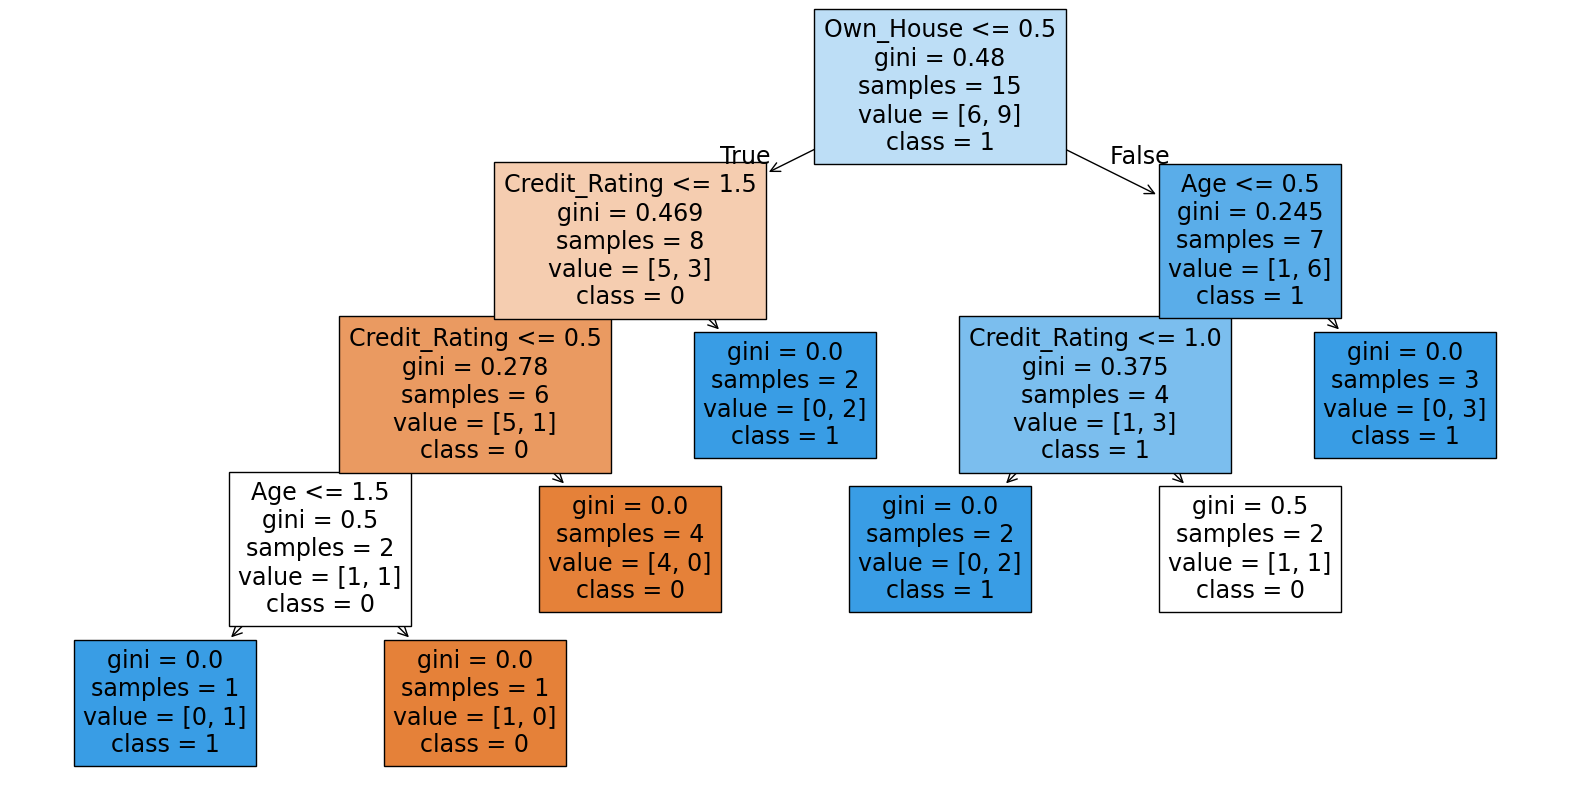

In [87]:
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names = X.columns, class_names=['0','1'], filled=True)
plt.show()